<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="../src/copernicus-logo.png"><span style="margin-left: 40px"></span><img src="../src/cds-logo.jpeg">

# Data Analysis

During this phase, we will try to find some correlation and autocorrelation on the final dataframe as the result of data aggregation. According to the time series techniques, we will find a sampling of data related to coordinates, and then we will use the result dataset as the input for this phase. In the data analysis procedures, we will analyze some features of the dataset variables, their autocorrelations, correlations, and aspects related to the distribution of their values over time.

## Libraries Dependencies

In [3]:
# installation of dependencies for remote notebook (Jupyter or Google Colab)
# !pip install xarray 
# !pip install netCDF4 dask bottleneck
# !pip install pandas
# !pip install geopandas
# !pip install cdsapi
# !pip instal matplotlib
# !pip install sklearn

# installation of dependencies for local notebook
%pip install xarray 
%pip install netCDF4 dask bottleneck
%pip install pandas
%pip install geopandas
%pip install cdsapi
%pip install matplotlib
%pip install statsmodels
%pip install sklearn

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -

In [178]:
import pandas as pd # it is used for the time series management dataset.
import numpy as np # it is used to manage collections of values in the pandas dataframe.
import json # it is used to format data in JSON.
import matplotlib.pyplot as plt # plot results or data distribution.
import seaborn as sns # it is used just for zooming plots
sns.set(rc={'figure.figsize':(15, 8)}) # set the figure default size
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss # statistical tests
from statsmodels.stats.stattools import durbin_watson # residual autocorrelation test
from pandas.plotting import lag_plot # specific forecasting plot 
from matplotlib.axes._axes import _log as matplotlib_axes_logger # ignore plot warnings
import warnings # ignore general warnings
matplotlib_axes_logger.setLevel('ERROR') # display only plot errors
warnings.filterwarnings('ignore') # to supress warning given by an adaptation for some functions

## Loading Dataset

In [271]:
# number of the identification related to the first year on samples data.
j = 11 
# initialize the dataframe structure according to the data aggregation.
df = pd.DataFrame(columns=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])

# loading annual dataframes and concatenate with the past history until 2019.
for i in range(2016, 2019):
    tmp = pd.read_csv("../samples/italy-dtp-{}-{}.csv".format(i,j), usecols=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
    df = pd.concat([df, tmp])
    j += 1

In [272]:
# print the head of dataset.
data = df
df.head()

,time,lat,lon,discharge,temp,prec
0,2016-01-01 12:00:00,44.750378,7.56052,3.988281,6.876062,0.0
1,2016-01-02 12:00:00,44.750378,7.56052,3.983398,5.494745,0.0
2,2016-01-03 12:00:00,44.750378,7.56052,4.030762,3.512628,0.0
3,2016-01-04 12:00:00,44.750378,7.56052,4.053223,3.912592,0.0
4,2016-01-05 12:00:00,44.750378,7.56052,4.042969,5.097375,0.0


## Coordinates Plots

----------------------------------------
         lat       lon  discharge       temp                 time      prec
0  40.519886  8.314602   0.114837  17.094890  2016-01-01 12:00:00  0.000017
1  40.520874  8.373312   0.154153  16.161252  2016-01-01 12:00:00  0.000017
2  40.521824  8.432023   0.352153  15.186535  2016-01-01 12:00:00  0.000018
3  40.522743  8.490736   0.496620  14.969994  2016-01-01 12:00:00  0.000019
4  40.523624   8.54945   0.837323  15.209411  2016-01-01 12:00:00  0.000019
----------------------------------------


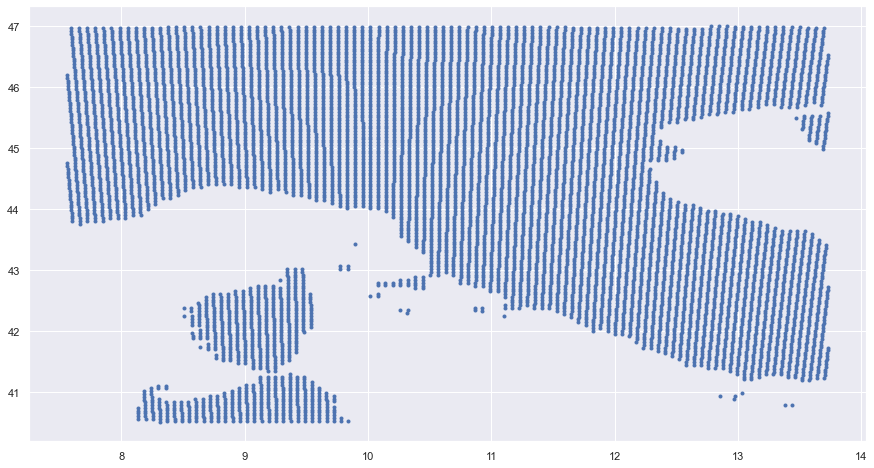

In [273]:
df_coordinates = df[df['discharge'] != 0]
df_coordinates = df.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
df_coordinates = df_coordinates.aggregate(aggregation_functions)

print('-'*40)
print(df_coordinates.head())
print('-'*40)
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.')

First of all, we need to filter North Italy coordinates only on river locations based on a proximity pattern matching where we assign the measurement of discharge to the nearest river. We filterd in the matching_points notebooks these points. So, we can associate each value with the filtered one.

In [274]:
# set the coordinates as index of the dataframe
df_drop = df.drop(columns = ['time', 'discharge', 'temp', 'prec'], inplace=False)
df['coords'] = df_drop.apply(tuple, axis=1)
df = df.set_index(['coords', 'time'])
df.tail()

lat        lon discharge  \
coords                time                                                 
(41.23425, 13.701608) 2018-12-27 12:00:00  41.23425  13.701608  0.231445   
                      2018-12-28 12:00:00  41.23425  13.701608  0.202148   
                      2018-12-29 12:00:00  41.23425  13.701608  0.176758   
                      2018-12-30 12:00:00  41.23425  13.701608  0.154297   
                      2018-12-31 12:00:00  41.23425  13.701608  0.136719   

                                               temp      prec  
coords                time                                     
(41.23425, 13.701608) 2018-12-27 12:00:00  7.397058  0.000222  
                      2018-12-28 12:00:00  8.206964  0.000143  
                      2018-12-29 12:00:00  7.938043  0.000014  
                      2018-12-30 12:00:00  7.159845  0.000021  
                      2018-12-31 12:00:00  5.911279       0.0

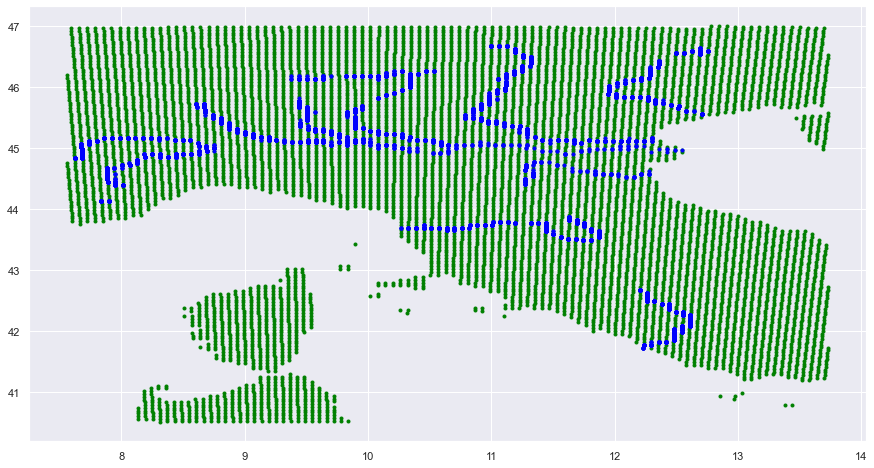

In [275]:
# filter points from original dataset to geojson coordinates related to river positions.
coords = json.load(open('../app/static/data/points.geojson', 'r'))
lats = []
longs = []
for coord in coords['features'][:]:
    sample = coord['geometry']['coordinates']
    lats.append(sample[1])
    longs.append(sample[0])

# plot coordinates
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='green')
plt.plot(longs, lats, '.', color='blue')



The previous plot shows the interested data from the original dataset related to river discharge measurements. Actually, our dataframe contains the total amount of coordinates of the North Italy, so we need to delete coordinates by index using a patter matching between the pair of river coordinates with dataframe indices. 

In [276]:
coords_tuple = []
for i in range(len(lats)):
    coords_tuple.append(tuple([lats[i], longs[i]]))
coords_tuple[:10]

[(45.13582, 9.130593),
 (45.13582, 9.130593),
 (45.136322, 9.194049),
 (45.136322, 9.194049),
 (45.136322, 9.194049),
 (45.136322, 9.194049),
 (45.136322, 9.194049),
 (45.136322, 9.194049),
 (45.136322, 9.194049),
 (45.136322, 9.194049)]

In [277]:
rivers = pd.DataFrame()
rivers = data[data['coords'].isin(coords_tuple)]

In [278]:
rivers.head()

,time,lat,lon,discharge,temp,prec,coords
19032,2016-01-01 12:00:00,44.841927,7.619702,17.01294,6.401208,0.0,"(44.841927, 7.6197023)"
19033,2016-01-02 12:00:00,44.841927,7.619702,16.999512,5.059595,0.0,"(44.841927, 7.6197023)"
19034,2016-01-03 12:00:00,44.841927,7.619702,17.18164,3.362756,0.0,"(44.841927, 7.6197023)"
19035,2016-01-04 12:00:00,44.841927,7.619702,17.444336,3.699884,0.0,"(44.841927, 7.6197023)"
19036,2016-01-05 12:00:00,44.841927,7.619702,17.520996,5.418665,0.0,"(44.841927, 7.6197023)"


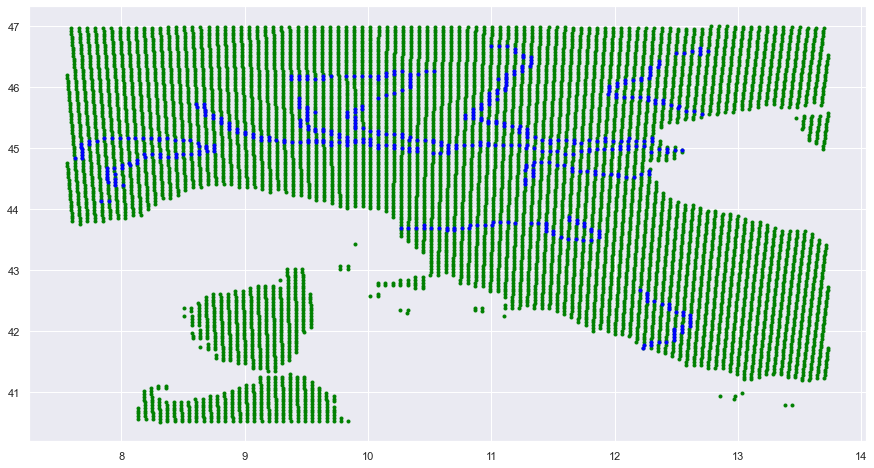

In [279]:
coords_rivers = rivers.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
coords_rivers = coords_rivers.aggregate(aggregation_functions)
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='green')
plt.plot(coords_rivers['lon'], coords_rivers['lat'], '.', color='blue')

In [280]:
coords_rivers.head()

,lat,lon,discharge,temp,time,prec
0,41.730213,12.233403,184.732792,16.386868,2016-01-01 12:00:00,0.000023
1,41.774025,12.294938,184.413408,16.358723,2016-01-01 12:00:00,0.000022
2,41.77538,12.235047,0.380298,16.296727,2016-01-01 12:00:00,0.000022
3,41.81637,12.416491,182.045766,16.538576,2016-01-01 12:00:00,0.000024
4,41.817795,12.356562,183.546608,16.407125,2016-01-01 12:00:00,0.000023


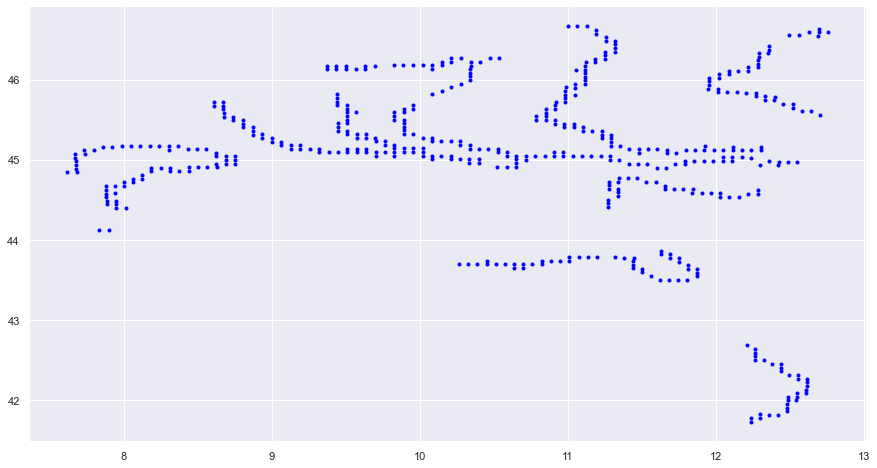

In [281]:
plt.plot(coords_rivers['lon'], coords_rivers['lat'], '.', color='blue')

The last plot shows the difference in the locations stored in the final dataset. So, we can already use data to analyze their correlation with features and past values over time. We will analyze autocorrelation and feature correlations using different statistical tests to accept or refuse our different hypotheses on data observations. Then we can make some conclusions that may help for the modeling phase.

## Data Correlations

This section shows some statistical analysis that can retrieve important information about the behavior of time series related to one or more features. According to our analysis, we need to consider only river locations and ignore the approximation given by coordinates that do not hit the river surface (approximately in the distance greater than 2.5 km).

In [282]:
rivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527176 entries, 19032 to 2719979
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   time       527176 non-null  object
 1   lat        527176 non-null  object
 2   lon        527176 non-null  object
 3   discharge  527176 non-null  object
 4   temp       527176 non-null  object
 5   prec       527176 non-null  object
 6   coords     527176 non-null  object
dtypes: object(7)
memory usage: 32.2+ MB


Rivers dataset has 6 columns with non-null representations. It consists in different time series filtered by geographical location given by latitude and longitude values combinations. Discharges, temperatures and precipitations changes over time for a same location and gives a time series visualization. The latitude and longitude are duplicated in 3 different columns: 2 for single values and 1 with a pair.

In [283]:
print('Total Points: {}'.format(rivers['coords'].nunique()))
coordinates = list(set(rivers['coords'])) # we take each coordinates 1 time.

Total Points: 481


According to the previous output, we have 481 different unique points with a related time series for discharge, temperature and precipitation fields.

In [284]:
rivers['time']

19032      2016-01-01 12:00:00
19033      2016-01-02 12:00:00
19034      2016-01-03 12:00:00
19035      2016-01-04 12:00:00
19036      2016-01-05 12:00:00
                  ...         
2719975    2018-12-27 12:00:00
2719976    2018-12-28 12:00:00
2719977    2018-12-29 12:00:00
2719978    2018-12-30 12:00:00
2719979    2018-12-31 12:00:00
Name: time, Length: 527176, dtype: object

We prepare data for splitting in time and locations. We already add a column related to the combination to latitude and longitude in an unique value. So, we let only split the time. In our case, time series is already daily because every measurement is done only 1 time per day at 12:00 a.m. and we can divide the $datetime$ only on days, months and years.

In [361]:
rivers.head()

,time,lat,lon,discharge,temp,prec,coords
19032,2016-01-01 12:00:00,44.841927,7.619702,17.01294,6.401208,0.0,"(44.841927, 7.6197023)"
19033,2016-01-02 12:00:00,44.841927,7.619702,16.999512,5.059595,0.0,"(44.841927, 7.6197023)"
19034,2016-01-03 12:00:00,44.841927,7.619702,17.18164,3.362756,0.0,"(44.841927, 7.6197023)"
19035,2016-01-04 12:00:00,44.841927,7.619702,17.444336,3.699884,0.0,"(44.841927, 7.6197023)"
19036,2016-01-05 12:00:00,44.841927,7.619702,17.520996,5.418665,0.0,"(44.841927, 7.6197023)"


In [363]:
coordinates

[(45.225395, 9.065623),
 (44.950962, 8.690675),
 (45.22481, 9.002067),
 (42.084316, 12.547628),
 (44.578274, 7.9451356),
 (45.124073, 11.7957),
 (45.0442, 11.032715),
 (44.627335, 11.842756),
 (42.497784, 12.261804),
 (44.622078, 7.880634),
 (44.90336, 8.502166),
 (45.0414, 11.286102),
 (45.83606, 12.269179),
 (45.945194, 11.0497675),
 (45.404663, 11.039449),
 (45.068577, 7.673447),
 (44.126316, 7.899032),
 (45.02546, 12.23604),
 (46.551872, 12.495053),
 (45.093212, 9.511738),
 (45.81521, 10.083521),
 (44.635006, 11.339725),
 (45.58913, 9.571321),
 (45.081112, 11.667483),
 (43.640488, 11.502131),
 (45.044804, 10.969364),
 (45.042877, 11.159411),
 (45.175777, 11.352728),
 (45.127728, 8.432666),
 (46.26527, 10.278568),
 (45.13936, 9.892114),
 (45.083958, 11.477321),
 (43.819008, 11.6308),
 (44.94492, 11.726679),
 (46.175556, 9.954727),
 (42.264885, 12.555226),
 (44.951733, 8.753917),
 (45.169765, 8.240933),
 (45.631092, 10.915665),
 (45.720608, 10.981305),
 (45.12183, 11.922558),
 (46.22

In [364]:
# Po river on the source side
source_po = rivers[rivers['coords'] == (44.841927, 7.6197023)]
source_po = source_po.drop(columns=['lat', 'lon', 'coords'])

# Po river on the outfall
outfall_po = rivers[rivers['coords'] ==  (44.97764, 12.360751)]
outfall_po = outfall_po.drop(columns=['lat', 'lon', 'coords'])

print('Source Po:')
print("-"*60)
print(source_po.head())
print("-"*60)
print('Outfall Po:')
print(outfall_po.head())


Source Po:
------------------------------------------------------------
                      time  discharge      temp prec
19032  2016-01-01 12:00:00   17.01294  6.401208  0.0
19033  2016-01-02 12:00:00  16.999512  5.059595  0.0
19034  2016-01-03 12:00:00   17.18164  3.362756  0.0
19035  2016-01-04 12:00:00  17.444336  3.699884  0.0
19036  2016-01-05 12:00:00  17.520996  5.418665  0.0
------------------------------------------------------------
Outfall Po:
                        time  discharge      temp      prec
2504172  2016-01-01 12:00:00  383.24854  1.047815       0.0
2504173  2016-01-02 12:00:00  377.40283  1.707208       0.0
2504174  2016-01-03 12:00:00  390.51807 -1.298499  0.000001
2504175  2016-01-04 12:00:00  391.16162   3.07052  0.000002
2504176  2016-01-05 12:00:00  414.31982  6.081445  0.000006


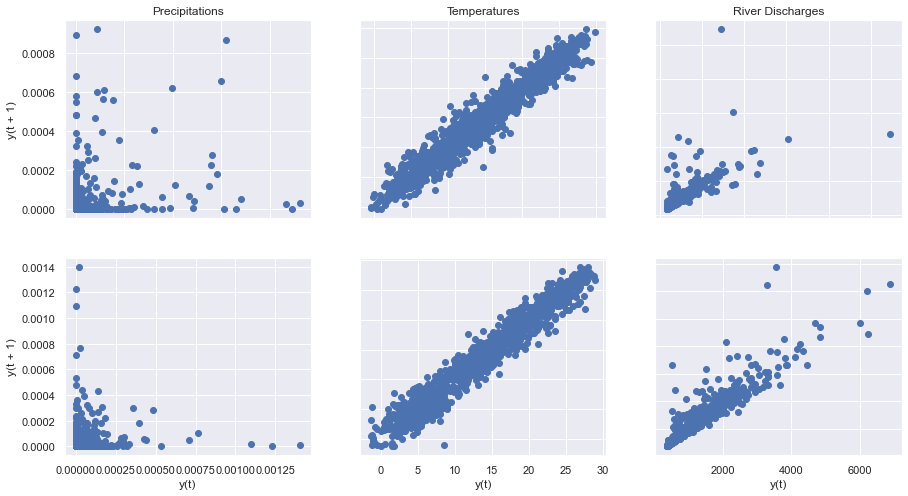

In [365]:
fig, axs = plt.subplots(2, 3)

lag_plot(source_po['prec'], ax=axs[0,0])
axs[0, 0].set_title('Precipitations')

lag_plot(source_po['temp'], ax=axs[0,1])
axs[0, 1].set_title('Temperatures')

lag_plot(source_po['discharge'], ax=axs[0,2])
axs[0, 2].set_title('River Discharges')


lag_plot(outfall_po['prec'], ax=axs[1,0])
axs[0, 0].set_title('Precipitations')

lag_plot(outfall_po['temp'], ax=axs[1,1])
axs[0, 1].set_title('Temperatures')

lag_plot(outfall_po['discharge'], ax=axs[1,2])
axs[0, 2].set_title('River Discharges')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

The lag plot can show if there is some autocorrelation related to the linearity of the distribution. Images belove show positive linear trends for temperature and discharge, and this should be an observation related to positive autocorrelations for these features. Meanwhile, precipitations have a significant amount of outliers, and it is not even linear, so it does not present any autocorrelation.

## Augmented Dickey-Fuller Tests

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series. So, we can use it to test the stationary for the temperatures, precipitations and discharges on the selected samples.

In [403]:
adfuller(source_po['temp'])

(-1.9837638568145588,
 0.2937371411536763,
 15,
 1080,
 {'1%': -3.436419361753321,
  '5%': -2.864219865461312,
  '10%': -2.5681968527091907},
 4286.900838395533)

In [397]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary

print('ADF on River Discharges:')
DIS = np.array(source_po['discharge'])
result = adfuller(DIS)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

print('-'*40)
print('ADF on Precipitations:')
PREC = np.array(source_po['prec'])
result = adfuller(PREC)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

print('-'*40)
print('ADF on Air Temperatures:')
TEMP = np.array(source_po['temp'])
result = adfuller(TEMP)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF on River Discharges:
ADF Statistic: -6.150168453892858
p-value: 7.596121087606247e-08
H0 rejected: It is stationary
Critical Values:
	1%: -3.4363635475753824
	5%: -2.864195245967465
	10%: -2.5681837404258903
----------------------------------------
ADF on Precipitations:
ADF Statistic: -25.007133936252043
p-value: 0.0
H0 rejected: It is stationary
Critical Values:
	1%: -3.436336023678866
	5%: -2.8641831050780513
	10%: -2.568177274243656
----------------------------------------
ADF on Air Temperatures:
ADF Statistic: -1.9837638568145588
p-value: 0.2937371411536763
H0 accepted: It is not stationary
Critical Values:
	1%: -3.436419361753321
	5%: -2.864219865461312
	10%: -2.5681968527091907


In [398]:
print('ADF on River Discharges:')
DIS2 = np.array(outfall_po['discharge'])
result = adfuller(DIS)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

print('-'*40)
print('ADF on Precipitations:')
PREC2 = np.array(outfall_po['prec'])
result = adfuller(PREC)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

print('-'*40)
print('ADF on Air Temperatures:')
TEMP2 = np.array(outfall_po['temp'])
result = adfuller(TEMP)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF on River Discharges:
ADF Statistic: -6.150168453892858
p-value: 7.596121087606247e-08
H0 rejected: It is stationary
Critical Values:
	1%: -3.4363635475753824
	5%: -2.864195245967465
	10%: -2.5681837404258903
----------------------------------------
ADF on Precipitations:
ADF Statistic: -25.007133936252043
p-value: 0.0
H0 rejected: It is stationary
Critical Values:
	1%: -3.436336023678866
	5%: -2.8641831050780513
	10%: -2.568177274243656
----------------------------------------
ADF on Air Temperatures:
ADF Statistic: -1.9837638568145588
p-value: 0.2937371411536763
H0 accepted: It is not stationary
Critical Values:
	1%: -3.436419361753321
	5%: -2.864219865461312
	10%: -2.5681968527091907


ADF is a significant test based on Unit Root categories. The ADf expands the Dickey-Fuller Test including high order regressive process in the model. 

$ y_t = c + \beta t + \alpha y_{t-1} + \Theta_{1} \Lambda Y_{t-1} + \Theta_{2} \Lambda Y_{t-2}...+ \Theta_{p} \Lambda Y_{t-p} + e_t$ ; $ p \in [1..t] $ 

The Dickey-Fuller test has a null hypothesis of the existence of the unit root that can make the time series not stationary, which is equal to that $ \alpha = 1 $ in the previous equation. 

## KPSS Test 

Alternatively to the Augmented Dickey-Fuller test, the KPSS Test has a null hypothesis that confirms the stationary. So, we should reject the null hypothesis and accept the alternative one to determine the correct observation.

In [399]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

print('Source of Po:')
print('Discharge River KPSS:\n{}'.format(kpss_test(DIS)))
print('Air Temperature KPSS:\n{}'.format(kpss_test(TEMP)))
print('Precipitations KPSS:\n{}'.format(kpss_test(PREC)))

Source of Po:
KPSS Statistic: 0.36774265484341645
p-value: 0.09105920049852739
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Discharge River KPSS:
None
KPSS Statistic: 0.18511194678531637
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Air Temperature KPSS:
None
KPSS Statistic: 0.1057354558690137
p-value: 0.1
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Precipitations KPSS:
None


In [394]:
print('Ovefall of Po:')
print('Discharge River KPSS:\n{}'.format(kpss_test(DIS2)))
print('Air Temperature KPSS:\n{}'.format(kpss_test(outfall_po['temp'].diff().dropna())))
print('Precipitations KPSS:\n{}'.format(kpss_test(PREC2)))

Ovefall of Po:
KPSS Statistic: 0.2865490643897923
p-value: 0.1
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Discharge River KPSS:
None
KPSS Statistic: 0.2084880937530909
p-value: 0.1
num lags: 29
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Air Temperature KPSS:
None
KPSS Statistic: 0.30212068291116284
p-value: 0.1
num lags: 11
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Precipitations KPSS:
None
